In [1]:
import torch
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
torch.cuda.empty_cache()

# inference_edit.py

In [11]:
from diffusers import DiffusionPipeline
import numpy as np
from PIL import Image
import torch
import sys
import os
from tqdm import tqdm
from unilip.constants import *
from unilip.model.builder import load_pretrained_model_general
from unilip.utils import disable_torch_init
from unilip.mm_utils import get_model_name_from_path
from unilip.pipeline_edit import CustomEditPipeline
import random

from transformers import AutoProcessor



def create_image_grid(images, rows, cols):
    """Creates a grid of images and returns a single PIL Image."""

    assert len(images) == rows * cols

    width, height = images[0].size
    grid_width = width * cols
    grid_height = height * rows

    grid_image = Image.new('RGB', (grid_width, grid_height))

    for i, image in enumerate(images):
        x = (i % cols) * width
        y = (i // cols) * height
        grid_image.paste(image, (x, y))

    return grid_image

def add_template(prompt):
    instruction = ('<|im_start|>user\n{input}<|im_end|>\n'
                 '<|im_start|>assistant\n<img>')
    pos_prompt = instruction.format(input=prompt[0])

    cfg_prompt = instruction.format(input=prompt[1])
    return [pos_prompt, cfg_prompt]

def set_global_seed(seed=42):

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


In [12]:
# model_path = sys.argv[1]
model_path = "UniLIP-3B"

disable_torch_init()
model_path = os.path.expanduser(model_path)
model_name = get_model_name_from_path(model_path)
tokenizer, multi_model, context_len = load_pretrained_model_general('UniLIP_InternVLForCausalLM', model_path, None, model_name)
image_processor = AutoProcessor.from_pretrained(multi_model.config.mllm_hf_path).image_processor

pipe = CustomEditPipeline(multimodal_encoder=multi_model, tokenizer=tokenizer, image_processor=image_processor)

generator = torch.Generator(device=multi_model.device).manual_seed(42)


class name!!!!!! UniLIP_InternVLForCausalLM <class 'unilip.model.language_model.unilip_internvl.UniLIP_InternVLForCausalLM'>
should no drop out InternVisionModel(
  (embeddings): InternVisionEmbeddings(
    (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
  )
  (encoder): InternVisionEncoder(
    (layers): ModuleList(
      (0): InternVisionEncoderLayer(
        (attn): InternAttention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (mlp): InternMLP(
          (act): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        )
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (norm2): LayerNorm((1024,), ep

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  2.54it/s]


In [13]:
prompt = "Replace the camper van in the image with a hot air balloon."
input_image_path = "demo/edit_input.jpg" #"../demo/edit_input.jpg"
input_image = Image.open(input_image_path)
set_global_seed(seed=42)
gen_images = []
for i in range(1):
    multimodal_prompts = add_template([f"Edit the image: {prompt}\n<image>", "Edit the image.\n<image>"])
    multimodal_prompts.append(input_image)
    gen_img = pipe(multimodal_prompts, guidance_scale=4.5, generator=generator)
    gen_images.append(gen_img)
print(f"finish {prompt}")

grid_image = create_image_grid(gen_images, 1, 1)
grid_image.save(f"{prompt[:100]}.png")





steps, guiance scale 20 4.5
9.5
finish Replace the camper van in the image with a hot air balloon.


In [4]:
multimodal_prompts

['<|im_start|>user\nEdit the image: Replace the camper van in the image with a hot air balloon.\n<image><|im_end|>\n<|im_start|>assistant\n<img>',
 '<|im_start|>user\nEdit the image.\n<image><|im_end|>\n<|im_start|>assistant\n<img>',
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x1024>]

# inference csgo fps

In [14]:
def build_sft_instruction_custom(pose_5d):
    """
    构造符合 CS2 自定义坐标系的 SFT 指令。

    参数:
    pose_5d (dict): 包含 x, y, z, yaw, pitch
        - x, y: [0, 1024]
        - z: [0.0, 1.0] (归一化后的高度)
        - yaw: 度数, 0=East, Clockwise
        - pitch: 度数, 0=Down, 180=Up
    """

    # 1. 坐标系定义块 (System Definition Block)
    # 这部分就像是给模型的 "System Prompt"，教它物理规则
    definition_text = (
        "Task: Generate a First-Person View (FPV) image of CS2 map 'de_dust2' based on the Radar Map and Camera Pose.\n"
        "Coordinate System Definition:\n"
        "- Map Size: 1024x1024 pixels.\n"
        "- Yaw: 0 degrees is East, increases Clockwise.\n"
        "- Pitch: 0 degrees is looking straight Down (at feet), 180 degrees is looking straight Up (at sky).\n"
        "- Z-Height: Normalized relative height (0.0 to 1.0)."
    )

    # 2. 具体数值块 (Data Block)
    # 格式化数值，保留适当精度，避免 token 浪费
    pose_str = (
        f"Position(x={pose_5d['x']:.1f}, y={pose_5d['y']:.1f}, z={pose_5d['z']:.3f}), "
        f"Rotation(yaw={pose_5d['angle_h']:.1f}, pitch={pose_5d['angle_v']:.1f})"
    )

    # 3. 组合最终指令
    # <image> 放在最后，代表输入的 Radar Map
    full_instruction = f"{definition_text}\n\nCurrent Camera Pose: {pose_str}\n<image>"

    return full_instruction


def add_csgo_template(prompt):
    # 这个函数负责把你的文本指令包装成模型能听懂的对话格式
    instruction = ('<|im_start|>user\n{input}<|im_end|>\n'
                   '<|im_start|>assistant\n<img>')

    # prompt[0] 是你的 SFT 完整指令 (包含 <image>)
    # prompt[1] 是 CFG 的负向/通用提示词
    pos_prompt = instruction.format(input=prompt[0])
    cfg_prompt = instruction.format(input=prompt[1])
    return [pos_prompt, cfg_prompt]


In [15]:
dust2_test_samples = [
    {
        "x": 471,
        "y": 366,
        "z": -14,
        "angle_h": 1.3957727141646166,
        "angle_v": 1.535916373365911,
        "map": "de_dust2",
        "file_frame": "file_num159_frame_191"
    },
    {
        "x": 676,
        "y": 211,
        "z": 36,
        "angle_h": 2.9035918059238095,
        "angle_v": 1.5563313673341312,
        "map": "de_dust2",
        "file_frame": "file_num309_frame_415"
    },
    {
        "x": 738,
        "y": 125,
        "z": 36,
        "angle_h": 1.6858029410991509,
        "angle_v": 1.593194843143008,
        "map": "de_dust2",
        "file_frame": "file_num215_frame_207"
    },
]

In [16]:
sample_loc_data = dust2_test_samples[0]

map_path = f"data/preprocessed_data/de_dust2/{sample_loc_data['map']}_radar_psd.png"
gt_fps_path = f"data/preprocessed_data/de_dust2/imgs/{sample_loc_data['file_frame']}.jpg"

sample_loc_data['angle_h'] = sample_loc_data['angle_h'] * 180 / np.pi
sample_loc_data['angle_v'] = sample_loc_data['angle_v'] * 180 / np.pi
prompt = build_sft_instruction_custom(sample_loc_data)

In [20]:
map_image = Image.open(map_path).convert("RGB")
set_global_seed(seed=42)
gen_images = []
for i in range(1):
    multimodal_prompts = multimodal_prompts = add_csgo_template([prompt, "Generate the image.\n<image>"])
    multimodal_prompts.append(map_image)
    gen_img = pipe(multimodal_prompts, guidance_scale=4.5, generator=generator)
    # Guidance Scale (CFG Scale)：
    #    如果生成的图像不像 CS2（画质差），尝试降低 scale (e.g., 2.0 - 3.5)。
    #    如果生成的图像位置不对（忽略了坐标指令），尝试提高 scale (e.g., 7.0 - 9.0)。
    gen_images.append(gen_img)
print(f"finish {prompt}")

grid_image = create_image_grid(gen_images, 1, 1)
grid_image.save(f"{prompt[:100]}.png")



steps, guiance scale 20 4.5
9.5
finish Task: Generate a First-Person View (FPV) image of CS2 map 'de_dust2' based on the Radar Map and Camera Pose.
Coordinate System Definition:
- Map Size: 1024x1024 pixels.
- Yaw: 0 degrees is East, increases Clockwise.
- Pitch: 0 degrees is looking straight Down (at feet), 180 degrees is looking straight Up (at sky).
- Z-Height: Normalized relative height (0.0 to 1.0).

Current Camera Pose: Position(x=471.0, y=366.0, z=-14.000), Rotation(yaw=80.0, pitch=88.0)
<image>


# FreedomIntelligence/ShareGPT-4o-Image: 2_text_and_image_to_image

In [21]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("FreedomIntelligence/ShareGPT-4o-Image", "2_text_and_image_to_image")

Generating train split: 100%|██████████| 46539/46539 [00:00<00:00, 80361.46 examples/s]


In [22]:
len(ds)

1

In [26]:
ds['train'][0]

{'input_prompt': 'Remove the wooden barrier running across the background.',
 'input_image': ['image/v2v_42971.png'],
 'input_image_resolution': [1024, 1024],
 'output_image': 'image/v2v_42970.png',
 'output_image_resolution': [1024, 1024]}

# 下载部分ShareGPT-4o-Image用于调试SFT Editing任务

针对 `FreedomIntelligence/ShareGPT-4o-Image` 这种大型图像数据集，通常数据会被切分成多个分片文件（例如 `.tar` 或 `.zip`）。

你完全不需要下载整个数据集。以下是三种针对不同需求的轻量化下载方案：

### 方案 1：使用 CLI 下载特定分片（最推荐，适合本地开发）

如果你需要把文件下载到硬盘上给 `load_dataset("webdataset", ...)` 用，你可以只下载前几个 `.tar` 包。

使用 `huggingface-cli` 的 `--include` 参数配合通配符。

```bash
# 只下载 sharegpt4o_image_00000.tar 到 sharegpt4o_image_00005.tar (假设这是文件名格式)
# 或者更通用的：只下载包含 "0000" 的 tar 包
huggingface-cli download --repo-type dataset FreedomIntelligence/ShareGPT-4o-Image --include "*0000*.tar" --local-dir ./partial_data --resume-download

```

* **`--include`**: 这是关键。你可以指定文件名，支持通配符 `*`。
* **注意**: 你需要先去 Hugging Face 网页端的 "Files and versions" 页面看一眼具体的文件名格式（通常是 `data/train-00000-of-xxxxx.tar` 或类似的结构）。

假设该数据集的文件结构是 `data/*.tar`，你可以只下载第一个文件夹：

```bash
huggingface-cli download --repo-type dataset FreedomIntelligence/ShareGPT-4o-Image --include "data/sharegpt4o_image_00000.tar" --local-dir ./partial_data

```

---

### 方案 2：Python 脚本下载（灵活控制）

如果你想在 Python 代码里精确控制下载哪些文件，可以使用 `huggingface_hub` 库。

```python
from huggingface_hub import snapshot_download

# 只下载符合特定模式的文件
local_dir = snapshot_download(
    repo_id="FreedomIntelligence/ShareGPT-4o-Image",
    repo_type="dataset",
    local_dir="./partial_data",
    allow_patterns=["*.json", "*00000.tar"],  # 只下载元数据json和第一个tar包
    resume_download=True
)

print(f"数据已下载到: {local_dir}")

```

---

### 方案 3：流式加载（Streaming，不下载到硬盘）

如果你只是想快速调试代码逻辑，或者查看数据格式，**完全不需要下载文件**。直接使用 Hugging Face 的 `streaming=True` 模式。

数据会像看视频一样，边用边下，不占用硬盘空间。

```python
from datasets import load_dataset

# 1. 开启流式模式
dataset = load_dataset(
    "FreedomIntelligence/ShareGPT-4o-Image",
    split="train",
    streaming=True  # <--- 关键点
)

# 2. 只取前 100 个样本进行查看或调试
# 注意：流式数据集不能用 dataset[0] 访问，必须用迭代器
small_dataset = dataset.take(100)

for sample in small_dataset:
    print(sample.keys())
    # print(sample['image'])
    break

```

**适用场景**：

* 检查数据结构（key的名字）。
* 测试你的 Preprocessing / Transform 代码是否报错。
* 编写 Demo。

### 总结

* **要存文件测试训练代码**：用 **方案 1**，下载 `*00000.tar` 这样一个包就足够跑通流程了。
* **只是看一眼数据**：用 **方案 3**。

## 下载

In [1]:
from huggingface_hub import snapshot_download

# 只下载符合特定模式的文件
local_dir = snapshot_download(
    repo_id="FreedomIntelligence/ShareGPT-4o-Image",
    repo_type="dataset",
    local_dir="./partial_data",
    allow_patterns=["text_and_image_to_image.json", "text_and_image_to_image_part_0.tar"],  # 只下载元数据json和第一个tar包
    resume_download=True
)

print(f"数据已下载到: {local_dir}")

/home/jiahao/miniconda3/envs/UniLIP/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jiahao/miniconda3/envs/UniLIP/lib/python3.11/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Fetching 2 files: 100%|██████████| 2/2 [3:05:44<00:00, 5572.40s/it]

数据已下载到: /home/jiahao/task/UniLIP/partial_data


# vis eval

In [ ]:
import PIL


file_frame = "file_num2_frame_188"
dust2_img_path = f"outputs_eval/exp2/test_20260102_004758/gen_imgs/de_ancient/{file_frame}.jpg"
PIL.Image.open(dust2_img_path)

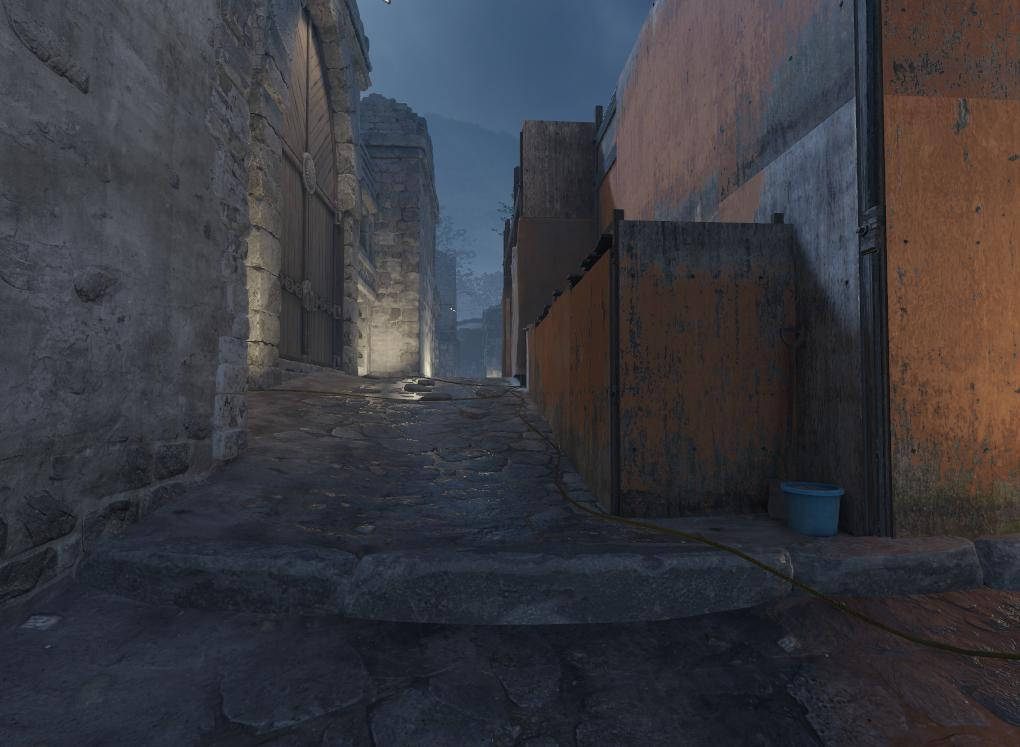

In [6]:
from PIL import Image


file_frame = "file_num3_frame_841"
ancient_img_path = f"data/preprocessed_data/de_ancient/imgs/{file_frame}.jpg"
PIL.Image.open(ancient_img_path)

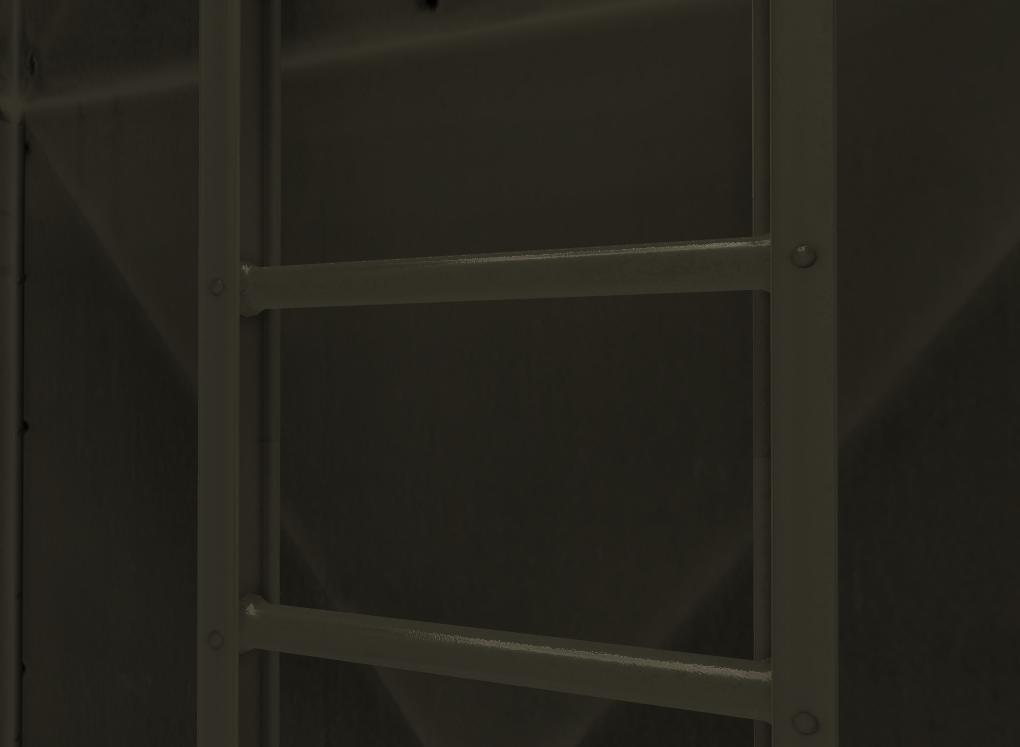

In [16]:
import PIL


file_frame = "file_num217_frame_114"
nuke_img_path = f"data/preprocessed_data/de_nuke/imgs/{file_frame}.jpg"
PIL.Image.open(nuke_img_path)

# und/aux图像动态掩码划分

In [ ]:
import torch

def split_image_tokens(input_ids, image_token_idx):
    # 1. 创建基础掩码：标记所有是图片 Token 的位置
    # Shape: [Batch, Seq_Len] (布尔值)
    all_img_mask = (input_ids == image_token_idx)

    # 2. 计算累加和：给每个图片 Token 编号 (1, 2, 3...)
    # 非图片位置虽然也有数值，但会被基础掩码过滤掉，所以不用担心
    # Shape: [Batch, Seq_Len]
    img_cumsum = all_img_mask.cumsum(dim=1)

    # 3. 计算每一行图片 Token 的总数
    # Shape: [Batch, 1] (保持维度以便广播)
    total_imgs = all_img_mask.sum(dim=1, keepdim=True)

    # 4. 计算分割点：总数的一半
    # Shape: [Batch, 1]
    half_point = total_imgs // 2

    # 5. 生成前一半的掩码 (und_image_idx)
    # 条件：是图片Token 且 当前累计序号 <= 一半
    und_image_idx = all_img_mask & (img_cumsum <= half_point)

    # 6. 生成后一半的掩码 (aux_image_idx)
    # 条件：是图片Token 且 当前累计序号 > 一半
    aux_image_idx = all_img_mask & (img_cumsum > half_point)

    return und_image_idx, aux_image_idx

# ================= 测试用例 =================
IMAGE_TOKEN_IDX = 99
# 假设 batch_size=2
# 第一行：2个文本token，4个图片token (2 Und, 2 Aux)
# 第二行：3个文本token，2个图片token (1 Und, 1 Aux)
input_ids = torch.tensor([
    [1, 2, 99, 99, 99, 99],
    [3, 4, 5, 99, 99, 0]     # 假设最后一个是pad，测试通用性
])

und_mask, aux_mask = split_image_tokens(input_ids, IMAGE_TOKEN_IDX)

print("Input IDs:\n", input_ids)
print("\nUND Mask (前一半):\n", und_mask)
print("\nAUX Mask (后一半):\n", aux_mask)

Input IDs:
 tensor([[ 1,  2, 99, 99, 99, 99],
        [ 3,  4,  5, 99, 99,  0]])

UND Mask (前一半):
 tensor([[False, False,  True,  True, False, False],
        [False, False, False,  True, False, False]])

AUX Mask (后一半):
 tensor([[False, False, False, False,  True,  True],
        [False, False, False, False,  True, False]])


# CUDA Memory

In [1]:
import torch


a = torch.ones((1024 * 3000000)).to("cuda:1")
b = torch.ones((1024 * 3000000)).to("cuda:1")

while True:
    c = a+b
    torch.cuda.empty_cache()

OutOfMemoryError: CUDA out of memory. Tried to allocate 11.45 GiB. GPU 1 has a total capacity of 94.97 GiB of which 11.11 GiB is free. Including non-PyTorch memory, this process has 34.96 GiB memory in use. Process 2541124 has 38.13 GiB memory in use. Process 2615712 has 10.72 GiB memory in use. Of the allocated memory 34.33 GiB is allocated by PyTorch, and 3.75 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [35]:
torch.cuda.empty_cache()